In [ ]:
!pip install geopandas

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import geopandas as gpd
import requests
from time import sleep

from shapely.geometry import Point
from geopy import distance 
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

### Задача:

Прогноз продаж одной из популярных моделей [фичерфонов](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D1%87%D0%B5%D1%80%D1%84%D0%BE%D0%BD) (на картинке ниже пример похожего устройства) в салонах МегаФона
![](https://39.img.avito.st/640x480/8468720439.jpg)

### Исходные данные:

Датасет содержит следующие поля:

1. `point_id` - Индентификатор салона
2. `lon` - Долгота точки
3. `lat` - Широта точки
4. `target` - Значение таргета, усредненное за несколько месяцев и отнормированное

### Требования к решению и советы:

Ниже приведен список из нескольких важных пунктов, необходимых для решения задания. Выполнение каждого из пунктов влияет на итоговую оценку. Вы можете выполнить каждый из пунктов разными способами, самым лучшим будет считаться вариант, когда всё получение и обработка данных будут реализованы на Питоне (пример: вы можете скачать данные из OSM через интерфейс на сайте overpass-turbo или с помощью библиотек `overpass`/`requests`. Оба варианта будут зачтены, но больше баллов можно заработать во втором случае)



1. Салоны расположены в нескольких разных городах, вам необходимо **определить город для каждого салона** (это понадобится во многих частях задания). К этому есть разные подходы. Вы можете провести [обратное геокодирование](https://en.wikipedia.org/wiki/Reverse_geocoding) с помощью геокодера [Nominatim](https://nominatim.org/), доступного через библиотеку `geopy` примерно вот так:
```python
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("52.509669, 13.376294")
print(location.address)
```
В таком случае, вам придется обрабатывать полученную строку адреса, чтобы извлечь название города. Также вы можете скачать из OSM или найти в любом другом источнике границы административно территориальных границ России и пересечь с ними датасет с помощью `geopandas.sjoin` (этот вариант более надежный, но нужно будет разобраться с тем, как устроены границы АТД в OSM, обратите внимание на [этот тег](https://wiki.openstreetmap.org/wiki/Key:admin_level))


2. **Используйте данные OSM**: подумайте, какие объекты могут влиять на продажи фичерфонов. Гипотеза: такие телефоны покупают люди, приезжающие в город или страну ненадолго, чтобы вставить туда отдельную симкарту для роуминга. Можно попробовать использовать местоположения железнодорожных вокзалов (изучите [этот тег](https://wiki.openstreetmap.org/wiki/Tag:railway%3Dstation)). Необходимо использовать хотя бы 5 разных типов объектов из OSM. Скорее всего, вам придется качать данные OSM отдельно для разных городов (см. пример для Нью-Йорка из лекции)


3. **Используйте разные способы генерации признаков**: описать положение салона МегаФона относительно станций метро можно разными способами - найти ***расстояние до ближайшей станции***, или же посчитать, сколько станций попадает в ***500 метровую буферную зону*** вокруг салона. Такие признаки будут нести разную информацию. Так же попробуйте поэкспериментировать с размерами буферных зон (представьте, что значат в реальности радиусы 100, 500, 1000 метров). Попробуйте посчитать расстояние до центра города, до других объектов.

4. **Сделайте визуализации**: постройте 2-3 карты для какого нибудь из городов - как распределен в пространстве таргет, где находятся объекты, полученные вами из OSM. Можете использовать любой инструмент - обычный `plot()`, `folium`, `keplergl`. Если выберете Кеплер, обязательно сохраните в файл конфиг карты, чтобы ее можно было воспроизвести. Сделать это можно вот так:

```python
import json
json_data = kepler_map.config
with open('kepler_config.json', 'w') as outfile:
    json.dump(json_data, outfile)
```
5. Задание не ограничено приведенными выше пунктами, попробуйте нагенерировать интересных признаков, найти в интернете дополнительные данные (в таком случае в комментарии к коду укажите ссылку на ресурс, откуда взяли данные)



6. Это довольно сложная задача - датасет очень маленький, данные по своей природе довольно случайны. Поэтому место и скор на Kaggle не будут играть решающую роль в оценке, но позволят заработать дополнительные баллы

Это часть кода для загрузки данных с каггл без скачивания данных на локальный компьютер. Пропустить до Read data, если уже есть эти данные.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"cheremgena","key":"971a5f79d9ba73479f2d6e406318adc0"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# List available datasets.
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-05-26 21:13:45           6156  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           3498  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1230  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1970  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [ ]:
!kaggle competitions download -c mf-geo-hw-april

mf_geo_train.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
mf_geo_test.csv: Skipping, found more recently modified local copy (use --force to force download)


### Read data

In [ ]:
train = pd.read_csv('mf_geo_train.csv')
test = pd.read_csv('mf_geo_test.csv')

# если в папке data разкомментить след строки и закоментить предудыщ строки

#train = pd.read_csv('data/mf_geo_train.csv')
#test = pd.read_csv('data/mf_geo_test.csv')

In [ ]:
train.head(3)

,point_id,lon,lat,target
0,ommNZCUV,37.590776,55.848630,-0.348157
1,nMe2LHPb,37.784210,55.750271,1.294206
2,ZgodVRqB,39.635721,47.213330,-1.039679


In [ ]:
test.head(2)

,point_id,lon,lat,target
0,F4lXR1cG,37.681242,55.74804,0.0091
1,4LJu4GTf,60.580910,56.79586,0.0091


In [ ]:
test.shape, train.shape

((107, 4), (425, 4))

In [ ]:
train.describe()

,lon,lat,target
count,425.000000,425.000000,425.000000
mean,45.466265,55.986388,0.009146
std,16.778159,2.734334,0.979238
min,29.765540,47.208802,-1.428660
25%,37.486227,55.609839,-0.650698
50%,37.707080,55.789394,-0.196887
75%,50.173675,56.350323,0.386584
max,93.023803,60.093366,7.215360


### Features treatment




#### add feature 'city'

In [ ]:
geolocator = Nominatim(user_agent="name_of_your_app")
location = geolocator.reverse([train.lat[0], train.lon[0]], language='ru')
#locationgeolocator.reverse([train.lot[0], train.lat[0]], language='ru')
location.raw, location

({'address': {'city': 'Москва',
   'country': 'Россия',
   'country_code': 'ru',
   'house_number': '6А',
   'postcode': '127106',
   'region': 'Центральный федеральный округ',
   'road': 'Сигнальный проезд',
   'state': 'Москва',
   'suburb': 'район Отрадное'},
  'boundingbox': ['55.8484227', '55.8487788', '37.5904705', '37.5911113'],
  'display_name': '6А, Сигнальный проезд, район Отрадное, Москва, Центральный федеральный округ, 127106, Россия',
  'lat': '55.84860075',
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
  'lon': '37.5907909',
  'osm_id': 99115245,
  'osm_type': 'way',
  'place_id': 112707148},
 Location(6А, Сигнальный проезд, район Отрадное, Москва, Центральный федеральный округ, 127106, Россия, (55.84860075, 37.5907909, 0.0)))

In [ ]:
# извлек городские округа и страны, т.к. в запросах довольно часто отсутствует названия городов
def get_addres(df):

  geolocator = Nominatim(user_agent="name_of_your_app")
  address_list = []

  for i in range(df.shape[0]):
    try:
      locate = geolocator.reverse([df.lat[i], df.lon[i]], language='ru')
      address_list.append(locate.raw['address']['city'])
    except:
      print(i)
      try:
        locate = geolocator.reverse([df.lat[i], df.lon[i]], language='ru')
        address_list.append(locate.raw['address']['state'])
      except:
        address_list.append('nan')
  return address_list

In [ ]:
a = get_addres(train)

49
70
78
129
232
293
313
340
385


In [ ]:
train['city'] = a

In [ ]:
at = get_addres(test)

98


In [ ]:
test['city'] = at
test['city'].unique()

array(['Москва', 'Екатеринбург', 'Казань', 'Санкт-Петербург', 'Самара',
       'Новосибирск', 'Нижний Новгород', 'Ростов-на-Дону', 'Уфа',
       'Красноярск', 'Зеленоград'], dtype=object)

### Using OSM and generate features

In [ ]:
# отрисовка нового признака по точкам
def scatter_plot_feature(new_data, name_plot, base_data = train, city = 'Москва'):
  sns.relplot(data = base_data[base_data.city == city], 
                    x = 'lat',  y = 'lon', hue = 'target')
  plt.scatter(new_data.lat, new_data.lon, color = 'green', s=4)
  plt.title(name_plot)
  plt.show()


# получение данных с запроса
def get_data_req(over_query,
                 ref = "http://overpass-api.de/api/interpreter"):

  response = requests.get(ref, 
                        params={'data': over_query})
  print(response.status_code)
  query_json = response.json()

  out_data = pd.DataFrame(query_json['elements'])
  if out_data.shape == (0, 0):
    return pd.DataFrame()
    
  else:
    out_data = out_data.join(pd.DataFrame([x['tags'] for x in query_json['elements']])).drop('tags', axis=1)
    return out_data


# получение нового признака на основе ближайшего объекта
def dist_nearest_new_feature(name_feature, data_for_feat, main_df, ncity = 'Москва'):
  
  if ncity == 'Москва':
    main_df[name_feature] = np.zeros(main_df.shape[0]) + 100000

  lat_moscow = data_for_feat.lat
  lon_moscow = data_for_feat.lon

  lon_moscow_close = []
  lat_moscow_close = []

  for i in range(main_df[main_df.city == ncity].shape[0]):
    idp = main_df[main_df.city == ncity].point_id.values[i]
    la0 = main_df[main_df.city == ncity].lat.values[i]
    lo0 = main_df[main_df.city == ncity].lon.values[i]             

    distance_l = (la0 - lat_moscow)**2 +(lo0 - lon_moscow)**2

    ind = distance_l.argmin()
    la = data_for_feat.iloc[ind].lat
    lo = data_for_feat.iloc[ind].lon

    main_df.loc[main_df.point_id == idp, name_feature] = distance.geodesic((la0, lo0),(la, lo)).m

    return main_df


def k_nearest_new_feature(name_feature, data_for_feat, 
                          main_df, ncity = 'Москва'):
  # подсчет количества объектов(возле каждого отдела)
  geo_series = gpd.GeoDataFrame({'geometry':[Point(a, b) for a,b in zip(data_for_feat.lon, 
                                                                        data_for_feat.lat)]})
  if ncity == 'Москва':
    main_df[name_feature] = np.zeros(main_df.shape[0])

  for i in range(main_df[main_df.city == ncity].shape[0]):
    idp = main_df[main_df.city == ncity].point_id.values[i]
    area = main_df[main_df.city == ncity]['area'].values[i]
    sum_points = 0
    for point in geo_series.geometry.values:
      sum_points += area.intersects(point)
    main_df.loc[main_df.point_id == idp, name_feature] = sum_points

#### Проверка функций для Москвы(отрисовка графиков и вывод таблиц)

In [ ]:
lon_min = 37.33
lat_min = 55.5
lon_max = 37.9
lat_max = 55.95

train['geometry'] = [Point(a, b) for a,b in zip(train.lon, train.lat)]
geo_train = gpd.GeoDataFrame(train)

test['geometry'] = [Point(a, b) for a,b in zip(test.lon, test.lat)]
geo_test = gpd.GeoDataFrame(test)

# Буферная зона с радиусом ~ 1.1 км
geo_train['area'] = geo_train.geometry.buffer(0.01) 
geo_test['area'] = geo_test.geometry.buffer(0.01)

bbox_ = lat_min,lon_min,lat_max,lon_max

In [ ]:
cities = train.city.unique()
cities

array(['Москва', 'Ростов-на-Дону', 'Красноярск', 'Санкт-Петербург', 'Уфа',
       'Казань', 'Екатеринбург', 'Нижний Новгород', 'Колпино',
       'Новосибирск', 'Самара', 'Зеленоград', 'Московская область',
       'Пушкин'], dtype=object)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

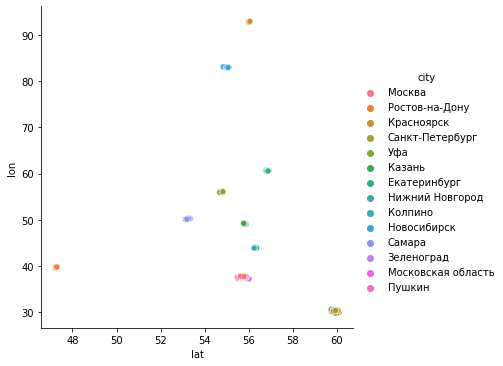

In [ ]:
sns.relplot(data = train, x = 'lat',  y = 'lon', hue = 'city')
plt.show()

Записей, где нет городов всего 7 штук, это единичные случаи покупки в окрестностях вышеуказанных городов, ими можно пренебречь.

##### Жд-вокзалы

In [ ]:
overpass_query = '''
[out:json];
(node["railway"="station"]({},{},{},{});
);
out body;
'''.format(*bbox_)

rails_osm = get_data_req(overpass_query)

200


In [ ]:
rails_osm.id.nunique(), rails_osm.shape[0]

(302, 302)

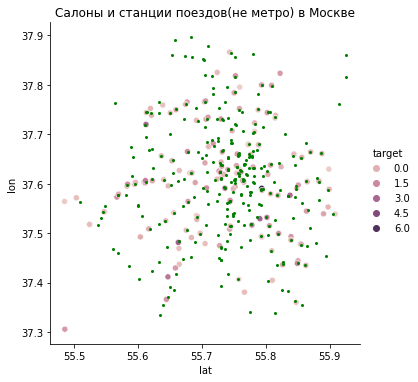

In [ ]:
scatter_plot_feature(rails_osm, 
                     'Салоны и станции поездов(не метро) в Москве')

In [ ]:
rails_osm.head(3)

,type,id,lat,lon,alt_name,esr:user,loc_name,loc_name:website,name,name:esr,nat_name,official_name,official_name:esr,official_name:esr:website,official_name:express-3,official_name:express-3:website,official_name:website,public_transport,railway,uic_name,uic_ref,express:user,name:en,old_name,wikidata,name:de,operator,wikipedia,colour,layer,name:be,name:ru,name:uk,network,station,subway,transport,opening_hours,train,name:fa,...,name:pl,name:pt,name:sv,alt_name:en,alt_name:uk,wikipedia:ru,start_date,name:es,name:fr,int_name,old_name:de,old_name:be,old_name:uk,name:ko,name:zh,depth,name:fi,turnstile,name:sk,addr:city,addr:street,image,internet_access,website,wheelchair:description,name:da,name:et,name:hu,name:no,official_status,name:bg,ticket_office,name:eo,disused:station,description,name:tr,location,fixme,name:nl,toilets:wheelchair
0,node,26999673,55.778834,37.653721,Москва-Октябрьская,060073,Москва-Ленинградская,http://www.tutu.ru/station.php?nnst=79310,Москва-Пассажирская,Москва-Пассажирская,Москва,Москва-Пассажирская,Москва-Пассажирская,http://cargo.rzd.ru/cargostation/public/ru?STR...,Москва-Октябрьская,http://bilet.ru/rus/TrainDirectory.htm?firstsy...,http://pass.rzd.ru/timetable/public/ru?STRUCTU...,station,station,Moskva Oktiabrskaia,2006004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,31447943,55.726797,37.450384,Кунцево,181704,NaN,NaN,Кунцевская,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,station,station,NaN,2001140,2001140,Kuntsevskaya,Кунцево I,Q4247313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node,54626031,55.806746,37.745942,NaN,199208,NaN,NaN,Черкизово,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,station,NaN,NaN,NaN,NaN,NaN,Q26849010,Tscherkisowo,ОАО «РЖД»,ru:Черкизово (станция),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dist_nearest_new_feature('dist_to_station', rails_osm[rails_osm.train == 'yes'],
                         geo_train)

k_nearest_new_feature('k_stations', rails_osm,
                         geo_train)

##### Узлы транспорта

In [ ]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query2 = '''
[out:json];
(node["public_transport"= "platform"]({},{},{},{});
);
out body;
'''.format(*bbox_)

platforms_osm  = get_data_req(overpass_query2)

200


In [ ]:
platforms_osm.head()

,type,id,lat,lon,name,public_transport,highway,old_name,bus,bench,bin,shelter,source,trolleybus,tactile_paving,check_date:shelter,alt_name,operator,route_ref,covered,name:en,name:be,name:ru,ref,note,fixme,wheelchair,lit,passenger_information_display,description,bus_stop:side,tram,share_taxi,transport_stop,route_ref:trolleybus,departures_board,network,start_date,survey:date,website,...,old_name2,layer,thermometer,source:location,name:fr,name:it,office,check_date:tactile_paving,image,esr:user,express:user,disused,kerb,shelter_type:source,passengers,bus_num,name:lt,wheelchair:description,bus_stop:category,illegal,note:photos,full_name,wikipedia,addr:postcode,construction,survey,name:cv,name:mn,name:my,access,fee,socket:device:USB-A,railway,nat_name,operator:contact:phone,addr:housenumber,ferry,depth,bus_routes,name:signed
0,node,60665302,55.829403,37.766592,Метрогородок,platform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,87761966,55.694214,37.424640,"Рябиновая улица, 51",platform,bus_stop,Молокозавод,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node,250559783,55.807910,37.418439,"Аллея ""Дорога Жизни""",platform,bus_stop,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node,252899807,55.731781,37.664659,"Метро ""Пролетарская""",platform,bus_stop,NaN,yes,yes,yes,yes,yandex panorams;bing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node,254393857,55.735781,37.656572,Улица Гвоздева,platform,bus_stop,NaN,yes,yes,NaN,yes,bing; yandex panorams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


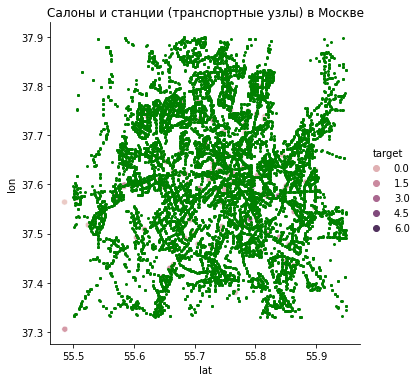

In [ ]:
scatter_plot_feature(platforms_osm, 'Салоны и станции (транспортные узлы) в Москве')

In [ ]:
k_nearest_new_feature('platforms', platforms_osm, geo_train)

In [ ]:
geo_train[geo_train.city == 'Москва'].corr()

,lon,lat,target,dist_to_station,k_stations,platforms
lon,1.000000,0.009057,-0.075638,0.010688,0.102399,0.366136
lat,0.009057,1.000000,0.007297,-0.098027,0.142740,0.079442
target,-0.075638,0.007297,1.000000,0.044637,0.087034,0.057820
dist_to_station,0.010688,-0.098027,0.044637,1.000000,-0.037852,0.005536
k_stations,0.102399,0.142740,0.087034,-0.037852,1.000000,0.173354
platforms,0.366136,0.079442,0.057820,0.005536,0.173354,1.000000


##### Торговые центры

In [ ]:
overpass_query1 = '''
[out:json];
(node["shop"="department_store"]({},{},{},{});
  node["shop"="mall"]({},{},{},{});
);
out body;
'''.format(*bbox_, *bbox_)

retails_osm = get_data_req(overpass_query1)

200


In [ ]:
retails_osm.head(2)

,type,id,lat,lon,name,shop,name:ru,opening_hours,website,addr:city,addr:postcode,addr:street,name:en,amenity,addr:housenumber,toilets,internet_access,ref,wheelchair,contact:phone,contact:website,contact:email,contact:facebook,alt_name,brand,brand:wikidata,brand:wikipedia,clothes,contact:vk,operator,phone,wheelchair:description,contact:instagram
0,node,310752865,55.604622,37.712301,Белград,mall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,514546547,55.710813,37.812293,Фамилия,department_store,Перекресток,Mo-Su 09:00-22:00,http://www.famil.ru/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


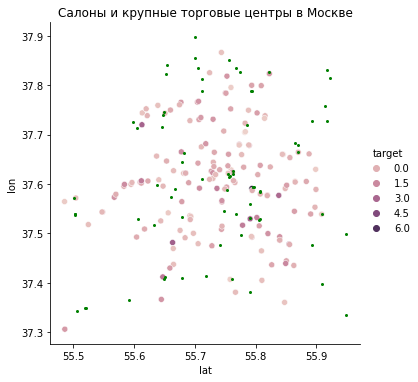

In [ ]:
scatter_plot_feature(retails_osm, 
                     'Салоны и крупные торговые центры в Москве')

In [ ]:
dist_nearest_new_feature('dist_to_mall', retails_osm, geo_train)
k_nearest_new_feature('k_malls', retails_osm, geo_train)

##### Эконом магазины (количество в окрестности салона)

In [ ]:
overpass_query3 = '''
[out:json];
(node["shop"="second_hand"]({},{},{},{});
node["shop"	= "variety_store"]({},{},{},{});
);
out body;
'''.format(*bbox_, *bbox_)

retails2_osm = get_data_req(overpass_query3)

200


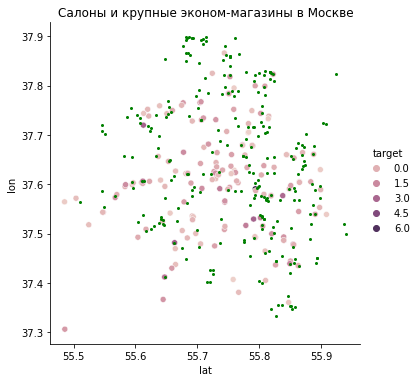

In [ ]:
scatter_plot_feature(retails2_osm, 
                     'Салоны и крупные эконом-магазины в Москве')

In [ ]:
dist_nearest_new_feature('dist_to_econom', retails2_osm, geo_train)
k_nearest_new_feature('k_econom', retails2_osm, geo_train)

##### Количество салонов(компании Мегафон и других компаний в окрестности салона)

In [ ]:
overpass_query5 = '''
[out:json];
(node["shop" = "mobile_phone"]({},{},{},{});
);
out body;
'''.format(*bbox_)

phones_osm = get_data_req(overpass_query5)

200


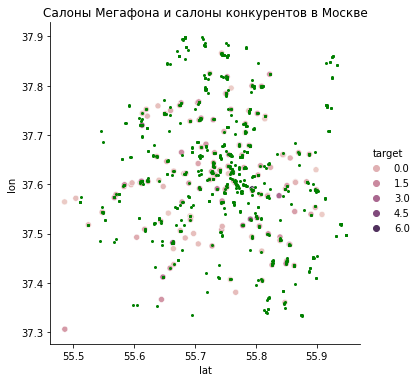

In [ ]:
scatter_plot_feature(phones_osm,
                     'Салоны Мегафона и салоны конкурентов в Москве')

In [ ]:
dist_nearest_new_feature('dist_to_phone_salons', phones_osm, geo_train)
k_nearest_new_feature('k_phone_salons', phones_osm, geo_train)

In [ ]:
geo_train[geo_train.city == 'Москва'].corr()

,lon,lat,target,dist_to_station,k_stations,platforms,dist_to_mall,k_malls,dist_to_econom,k_econom,dist_to_phone_salons,k_phone_salons
lon,1.000000,0.009057,-0.075638,0.010688,0.102399,0.366136,0.010688,-0.010053,0.010688,-0.005232,0.010688,0.200721
lat,0.009057,1.000000,0.007297,-0.098027,0.142740,0.079442,-0.098027,0.075190,-0.098027,0.129229,-0.098027,0.104852
target,-0.075638,0.007297,1.000000,0.044637,0.087034,0.057820,0.044637,0.128777,0.044637,0.205426,0.044637,0.176216
dist_to_station,0.010688,-0.098027,0.044637,1.000000,-0.037852,0.005536,1.000000,0.024842,1.000000,-0.082006,1.000000,-0.050109
k_stations,0.102399,0.142740,0.087034,-0.037852,1.000000,0.173354,-0.037852,0.342974,-0.037852,-0.074491,-0.037852,0.408972
platforms,0.366136,0.079442,0.057820,0.005536,0.173354,1.000000,0.005536,0.024411,0.005536,0.204131,0.005536,0.274524
dist_to_mall,0.010688,-0.098027,0.044637,1.000000,-0.037852,0.005536,1.000000,0.024842,1.000000,-0.082006,1.000000,-0.050109
k_malls,-0.010053,0.075190,0.128777,0.024842,0.342974,0.024411,0.024842,1.000000,0.024842,0.151485,0.024842,0.064270
dist_to_econom,0.010688,-0.098027,0.044637,1.000000,-0.037852,0.005536,1.000000,0.024842,1.000000,-0.082006,1.000000,-0.050109
k_econom,-0.005232,0.129229,0.205426,-0.082006,-0.074491,0.204131,-0.082006,0.151485,-0.082006,1.000000,-0.082006,0.239587


#### Для всех городов

Выполняется долго, так как расставлены time.sleep. Все для того, чтобы при запросе через request не выдало статус кода 429 (отказ из-за вожможной ddos)

Для обучающей части

In [ ]:
'dist_to_' + q3.split('"')[3]

'dist_to_department_store'

In [ ]:
def get_new_features_city(city_c, query, df,
                          ref_query = "http://overpass-api.de/api/interpreter", 
                          dist_nearest = True, k_nearest = True): 

  lat_min, lon_min = geo_train[geo_train.city == city_c][['lat', 'lon']].describe().loc['min']
  lat_max, lon_max = geo_train[geo_train.city == city_c][['lat', 'lon']].describe().loc['max']

  bbox_c = lat_min - 0.012, lon_min - 0.012, lat_max + 0.012, lon_max + 0.012

  n = 0
  j = 1
  while 1:
    try:
      if (query == q3) or (query == q4):
        new_data = get_data_req(query.format(*bbox_c, *bbox_c), ref_query)
      else:
        new_data = get_data_req(query.format(*bbox_c), ref_query)
      print('Данные с города {} загружены'.format(city_c))
      break
    except:
      print('При запросе возникла ошибка, пробую снова с задержкой')
      sleep(np.random.random()*10+3)
      n += 1
      if n == 5*j:
        j += 1
        if input(f'Уже было {n*j} попыток. Пробовать еще? [y/n]') == 'y':
          continue
        else: break

  if new_data.shape != (0, 0):
    if dist_nearest:
      if (city_c == 'Москва') and (query == q1):  
        dist_nearest_new_feature('dist_to_'  + query.split('"')[3], new_data[new_data.train == 'yes'],
                            df, ncity = city_c)
      else:
        dist_nearest_new_feature('dist_to_' + query.split('"')[3], new_data, df, ncity = city_c)

    if k_nearest:
      k_nearest_new_feature('k_near_' + query.split('"')[3], new_data, df, ncity = city_c)

  else: print('Такие объекты в городе не найдены')


q1 = '''
[out:json];
(node["railway"="station"]({},{},{},{});
);
out body;
'''

q2 = '''
[out:json];
(node["public_transport"= "platform"]({},{},{},{});
);
out body;
'''

q3 = '''
[out:json];
(node["shop"="department_store"]({},{},{},{});
  node["shop"="mall"]({},{},{},{});
);
out body;
'''

q4= '''
[out:json];
(node["shop"="second_hand"]({},{},{},{});
node["shop"	= "variety_store"]({},{},{},{});
);
out body;
'''

q5 =  '''
[out:json];
(node["shop" = "mobile_phone"]({},{},{},{});
);
out body;
'''

In [ ]:
for c in geo_train.city.unique():
  for quer in [q1,q2,q3,q4,q5]:
    get_new_features_city(c, quer, geo_train)

200
Данные с города Москва загружены
200
Данные с города Москва загружены
200
Данные с города Москва загружены
429
При запросе возникла ошибка, пробую снова с задержкой
200
Данные с города Москва загружены
200
Данные с города Москва загружены
429
При запросе возникла ошибка, пробую снова с задержкой
504
При запросе возникла ошибка, пробую снова с задержкой
200
Данные с города Ростов-на-Дону загружены
200
Данные с города Ростов-на-Дону загружены
200
Данные с города Ростов-на-Дону загружены
200
Данные с города Ростов-на-Дону загружены
200
Данные с города Ростов-на-Дону загружены
200
Данные с города Красноярск загружены
200
Данные с города Красноярск загружены
200
Данные с города Красноярск загружены
200
Данные с города Красноярск загружены
200
Данные с города Красноярск загружены
200
Данные с города Санкт-Петербург загружены
200
Данные с города Санкт-Петербург загружены
200
Данные с города Санкт-Петербург загружены
200
Данные с города Санкт-Петербург загружены
200
Данные с города Санкт-П

In [ ]:
for c in geo_train.city.unique():
  for quer in [q1,q2,q3,q4,q5]:
    get_new_features_city(c, quer, geo_test)

200
Данные с города Москва загружены
429
При запросе возникла ошибка, пробую снова с задержкой
200
Данные с города Москва загружены
504
При запросе возникла ошибка, пробую снова с задержкой
200
Данные с города Москва загружены
200
Данные с города Москва загружены
429
При запросе возникла ошибка, пробую снова с задержкой
200
Данные с города Москва загружены
200
Данные с города Ростов-на-Дону загружены
200
Данные с города Ростов-на-Дону загружены
200
Данные с города Ростов-на-Дону загружены
200
Данные с города Ростов-на-Дону загружены
200
Данные с города Ростов-на-Дону загружены
200
Данные с города Красноярск загружены
200
Данные с города Красноярск загружены
200
Данные с города Красноярск загружены
200
Данные с города Красноярск загружены
200
Данные с города Красноярск загружены
200
Данные с города Санкт-Петербург загружены
200
Данные с города Санкт-Петербург загружены
200
Данные с города Санкт-Петербург загружены
200
Данные с города Санкт-Петербург загружены
200
Данные с города Санкт-П

In [ ]:
g = geo_train.drop(geo_train[geo_train.city == 'nan'].index, axis = 0)
g.corr()

,lon,lat,target,dist_to_station,k_stations,platforms,dist_to_mall,k_malls,dist_to_econom,k_econom,dist_to_phone_salons,k_phone_salons,k_near_station,dist_to_platform,k_near_platform,dist_to_department_store,k_near_department_store,dist_to_second_hand,k_near_second_hand,dist_to_mobile_phone,k_near_mobile_phone
lon,1.000000,-0.247424,-0.029311,-0.033854,-0.340509,-0.329520,0.022822,-0.085931,0.022822,-0.194845,0.022822,-0.260002,-0.288113,-0.032630,-0.592966,-0.054281,-0.027065,-0.045315,-0.289021,-0.032857,-0.340509
lat,-0.247424,1.000000,-0.140264,0.006704,0.264646,-0.063932,0.002450,-0.015305,0.002450,-0.035887,0.002450,-0.049489,0.166625,0.007934,0.133492,0.026897,0.070702,0.026808,0.262044,0.007343,0.264646
target,-0.029311,-0.140264,1.000000,0.000249,0.047024,0.189399,0.017741,0.128872,0.017741,0.218108,0.017741,0.218508,0.143744,0.001319,0.013392,0.047091,-0.036010,-0.014668,0.097255,0.000985,0.047024
dist_to_station,-0.033854,0.006704,0.000249,1.000000,0.043020,0.106811,0.246545,0.033786,0.246545,0.045194,0.246545,0.075100,0.079925,0.999710,0.042226,0.919803,-0.023132,0.962155,0.029412,0.999718,0.043020
k_stations,-0.340509,0.264646,0.047024,0.043020,1.000000,0.145978,-0.028384,0.052744,-0.028384,0.145323,-0.028384,0.374584,0.485405,0.042930,0.470545,0.052075,0.148226,0.038559,0.681979,0.042564,1.000000
platforms,-0.329520,-0.063932,0.189399,0.106811,0.145978,1.000000,-0.056160,0.229267,-0.056160,0.566342,-0.056160,0.741465,0.393459,0.105263,0.623444,0.094187,-0.115559,0.099197,0.079685,0.105170,0.145978
dist_to_mall,0.022822,0.002450,0.017741,0.246545,-0.028384,-0.056160,1.000000,0.008892,1.000000,-0.103174,1.000000,-0.080452,-0.048980,0.264062,-0.027554,0.277224,0.020455,0.277313,-0.040519,0.265078,-0.028384
k_malls,-0.085931,-0.015305,0.128872,0.033786,0.052744,0.229267,0.008892,1.000000,0.008892,0.253366,0.008892,0.216542,0.310452,0.033794,0.127349,0.031204,0.444748,0.032518,0.078654,0.033794,0.052744
dist_to_econom,0.022822,0.002450,0.017741,0.246545,-0.028384,-0.056160,1.000000,0.008892,1.000000,-0.103174,1.000000,-0.080452,-0.048980,0.264062,-0.027554,0.277224,0.020455,0.277313,-0.040519,0.265078,-0.028384
k_econom,-0.194845,-0.035887,0.218108,0.045194,0.145323,0.566342,-0.103174,0.253366,-0.103174,1.000000,-0.103174,0.532247,0.164375,0.043057,0.338515,0.035648,-0.008603,0.038575,0.410809,0.042931,0.145323


Для тестовой выборки

In [ ]:
# загрузка датасетов если что прервется
geo_train.to_csv('geo_train.csv')
geo_test.to_csv('geo_test.csv')

In [ ]:
geo_train.shape, geo_test.shape

((425, 17), (107, 17))

In [ ]:
geo_train.head()

,point_id,lon,lat,target,city,geometry,area,dist_to_station,k_stations,platforms,dist_to_mall,k_malls,dist_to_econom,k_econom,dist_to_phone_salons,k_phone_salons
0,ommNZCUV,37.590776,55.848630,-0.348157,Москва,POINT (37.59078 55.84863),"POLYGON ((37.60078 55.84863, 37.60073 55.84765...",13.135333,7.0,27.0,4723.870534,0.0,7.623627,2.0,13.135333,7.0
1,nMe2LHPb,37.784210,55.750271,1.294206,Москва,POINT (37.78421 55.75027),"POLYGON ((37.79421 55.75027, 37.79416 55.74929...",100000.000000,8.0,37.0,100000.000000,0.0,100000.000000,2.0,100000.000000,8.0
2,ZgodVRqB,39.635721,47.213330,-1.039679,Ростов-на-Дону,POINT (39.63572 47.21333),"POLYGON ((39.64572 47.21333, 39.64567 47.21235...",1840.489679,0.0,0.0,100000.000000,0.0,100000.000000,0.0,100000.000000,0.0
3,0t2jNYdz,37.704570,55.782020,-1.169339,Москва,POINT (37.70457 55.78202),"POLYGON ((37.71457 55.78202, 37.71452 55.78104...",100000.000000,7.0,22.0,100000.000000,0.0,100000.000000,0.0,100000.000000,7.0
4,U27W4QJ7,37.643983,55.730188,-0.088837,Москва,POINT (37.64398 55.73019),"POLYGON ((37.65398 55.73019, 37.65393 55.72921...",100000.000000,12.0,21.0,100000.000000,0.0,100000.000000,0.0,100000.000000,12.0


In [ ]:
geo_test.head(3)

,point_id,lon,lat,target,city,geometry,area,dist_to_station,k_stations
0,F4lXR1cG,37.681242,55.748040,0.0091,Москва,POINT (37.68124 55.74804),"POLYGON ((37.69124 55.74804, 37.69119 55.74706...",7.142190,6.0
1,4LJu4GTf,60.580910,56.795860,0.0091,Екатеринбург,POINT (60.58091 56.79586),"POLYGON ((60.59091 56.79586, 60.59086 56.79488...",2920.586428,0.0
2,kLuAAN3s,37.598614,55.781357,0.0091,Москва,POINT (37.59861 55.78136),"POLYGON ((37.60861 55.78136, 37.60857 55.78038...",100000.000000,9.0


#### Подготовка данных

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
X_train = pd.concat([geo_train, geo_test], axis = 0)
X_train

,point_id,lon,lat,target,city,geometry,area,dist_to_station,k_near_station,dist_to_platform,k_near_platform,dist_to_department_store,k_near_department_store,dist_to_second_hand,k_near_second_hand,dist_to_mobile_phone,k_near_mobile_phone
0,ommNZCUV,37.590776,55.848630,-0.348157,Москва,POINT (37.59078 55.84863),"POLYGON ((37.60078 55.84863, 37.60073 55.84765...",8165.935969,2.0,25.172446,27.0,4723.870534,0.0,7.623627,2.0,13.135333,7.0
1,nMe2LHPb,37.784210,55.750271,1.294206,Москва,POINT (37.78421 55.75027),"POLYGON ((37.79421 55.75027, 37.79416 55.74929...",100000.000000,1.0,100000.000000,37.0,100000.000000,0.0,100000.000000,2.0,100000.000000,8.0
2,ZgodVRqB,39.635721,47.213330,-1.039679,Ростов-на-Дону,POINT (39.63572 47.21333),"POLYGON ((39.64572 47.21333, 39.64567 47.21235...",2674.668488,0.0,67.448751,20.0,618.086126,1.0,1026.333593,0.0,1840.489679,0.0
3,0t2jNYdz,37.704570,55.782020,-1.169339,Москва,POINT (37.70457 55.78202),"POLYGON ((37.71457 55.78202, 37.71452 55.78104...",100000.000000,2.0,100000.000000,22.0,100000.000000,0.0,100000.000000,0.0,100000.000000,7.0
4,U27W4QJ7,37.643983,55.730188,-0.088837,Москва,POINT (37.64398 55.73019),"POLYGON ((37.65398 55.73019, 37.65393 55.72921...",100000.000000,3.0,100000.000000,21.0,100000.000000,0.0,100000.000000,0.0,100000.000000,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,y8oQuX5v,30.353777,60.049792,0.009100,Санкт-Петербург,POINT (30.35378 60.04979),"POLYGON ((30.36378 60.04979, 30.36373 60.04881...",100000.000000,1.0,100000.000000,26.0,100000.000000,0.0,100000.000000,2.0,100000.000000,4.0
103,4nmfqUw0,92.928927,56.116262,0.009100,Красноярск,POINT (92.92893 56.11626),"POLYGON ((92.93893 56.11626, 92.93888 56.11528...",100000.000000,0.0,100000.000000,0.0,100000.000000,0.0,100000.000000,0.0,100000.000000,0.0
104,N9O45mAh,93.015993,56.023697,0.009100,Красноярск,POINT (93.01599 56.02370),"POLYGON ((93.02599 56.02370, 93.02594 56.02272...",100000.000000,0.0,100000.000000,7.0,100000.000000,0.0,100000.000000,0.0,100000.000000,1.0
105,h2InCLKa,30.381172,59.871149,0.009100,Санкт-Петербург,POINT (30.38117 59.87115),"POLYGON ((30.39117 59.87115, 30.39112 59.87017...",100000.000000,1.0,100000.000000,26.0,100000.000000,0.0,100000.000000,2.0,100000.000000,4.0


In [ ]:
y = X_train[['target']]
X_train = X_train.drop(['point_id', 'geometry', 'area', 'target', 'city'], axis = 1)

poly = PolynomialFeatures(3)
X_train = poly.fit_transform(X_train)
X_train = StandardScaler().fit_transform(X_train)
X_train

array([[ 0.        , -0.47117975, -0.05197439, ..., -0.76516467,
        -0.30964557, -0.09537764],
       [ 0.        , -0.45965588, -0.08802669, ...,  0.78188535,
         0.15779463, -0.05894148],
       [ 0.        , -0.3493518 , -3.21713941, ..., -0.76516469,
        -0.30969258, -0.16932794],
       ...,
       [ 0.        ,  2.83078703,  0.01219431, ..., -0.57178344,
        -0.3023881 , -0.16911234],
       [ 0.        , -0.90069314,  1.42243142, ...,  0.00836033,
        -0.19282078, -0.15552963],
       [ 0.        , -0.90676551,  1.44844132, ...,  0.9752666 ,
         0.28197093, -0.0121566 ]])

### Fit model

Использую Лассо всместо лин. регрессии


In [ ]:
from sklearn.linear_model import Lasso, Ridge

In [ ]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(X_train, y, test_size = 107)
model = Lasso().fit(X_train_, y_train_)

In [ ]:
mean_absolute_error(y_valid_, model.predict(X_valid_))

0.6033969573191829

### Make submission

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = model.predict(X_valid_)
submission.to_csv('my_submission_01.csv', index=False)